<a href="https://colab.research.google.com/github/MANOJ-80/Fraud-Detection-NM/blob/main/Credit_Card_Fraud_Detection_NM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imbalanced-learn joblib shap xgboost lightgbm catboost



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE


In [3]:
df = pd.read_csv('/content/creditcard.csv')
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.isnull().sum()


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [5]:
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344


In [6]:
df.shape

(284807, 31)

In [9]:
non_fraud_cases=len(df[df['Class']==0])
print('Number of Non Fraud Cases:',non_fraud_cases)

Number of Non Fraud Cases: 284315


In [10]:
fraud_cases=len(df[df['Class']==1])
print(' Number of Fraud Cases:',fraud_cases)


 Number of Fraud Cases: 492


In [12]:
fraud=df[df['Class']==1]
genuine=df[df['Class']==0]


In [13]:

scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])


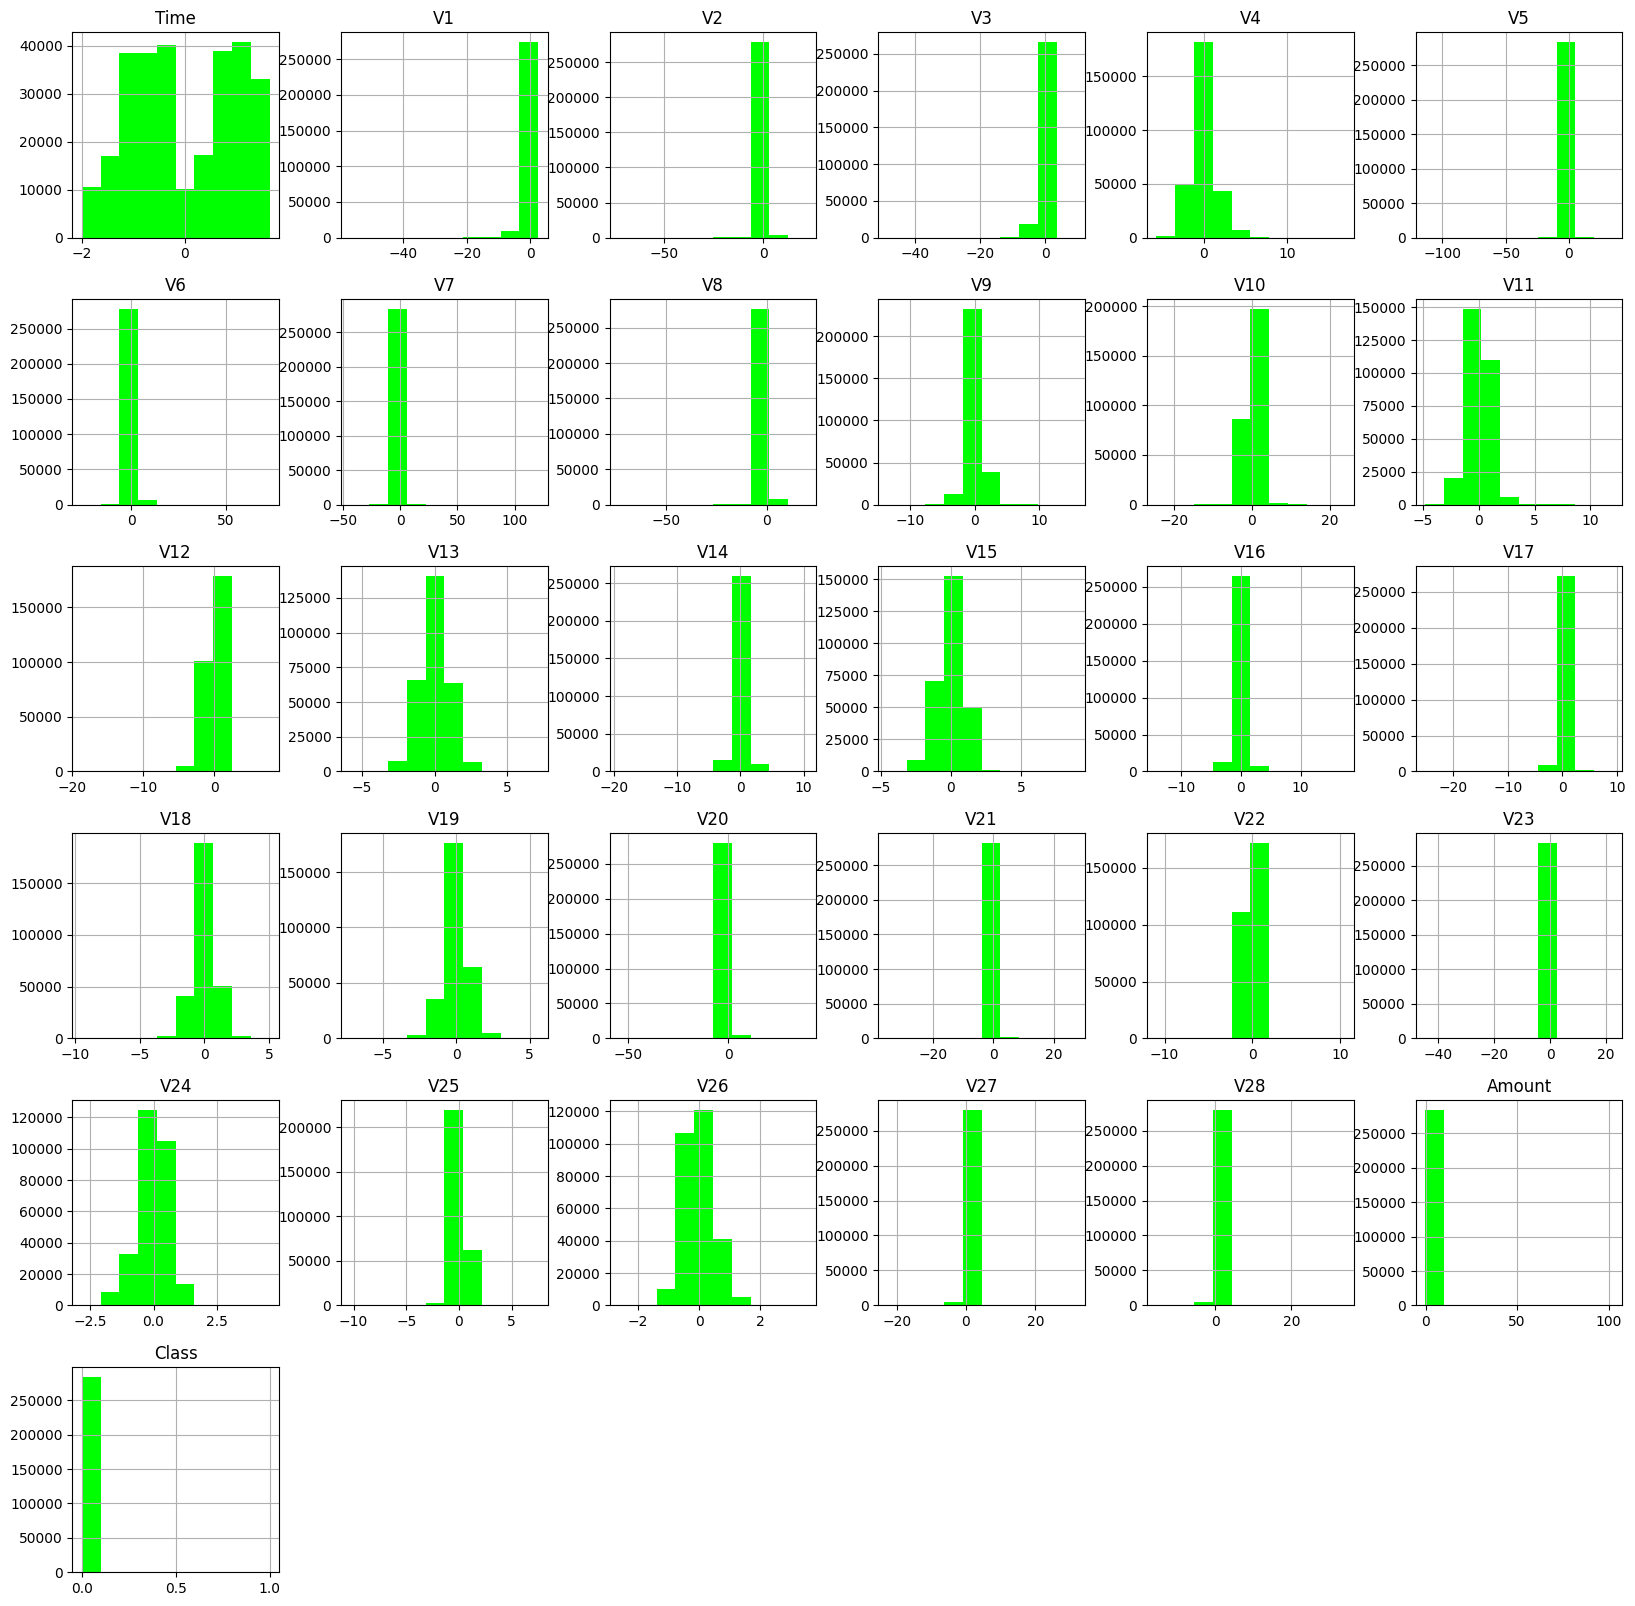

In [14]:
df.hist(figsize=(20,20),color='lime')
plt.show()

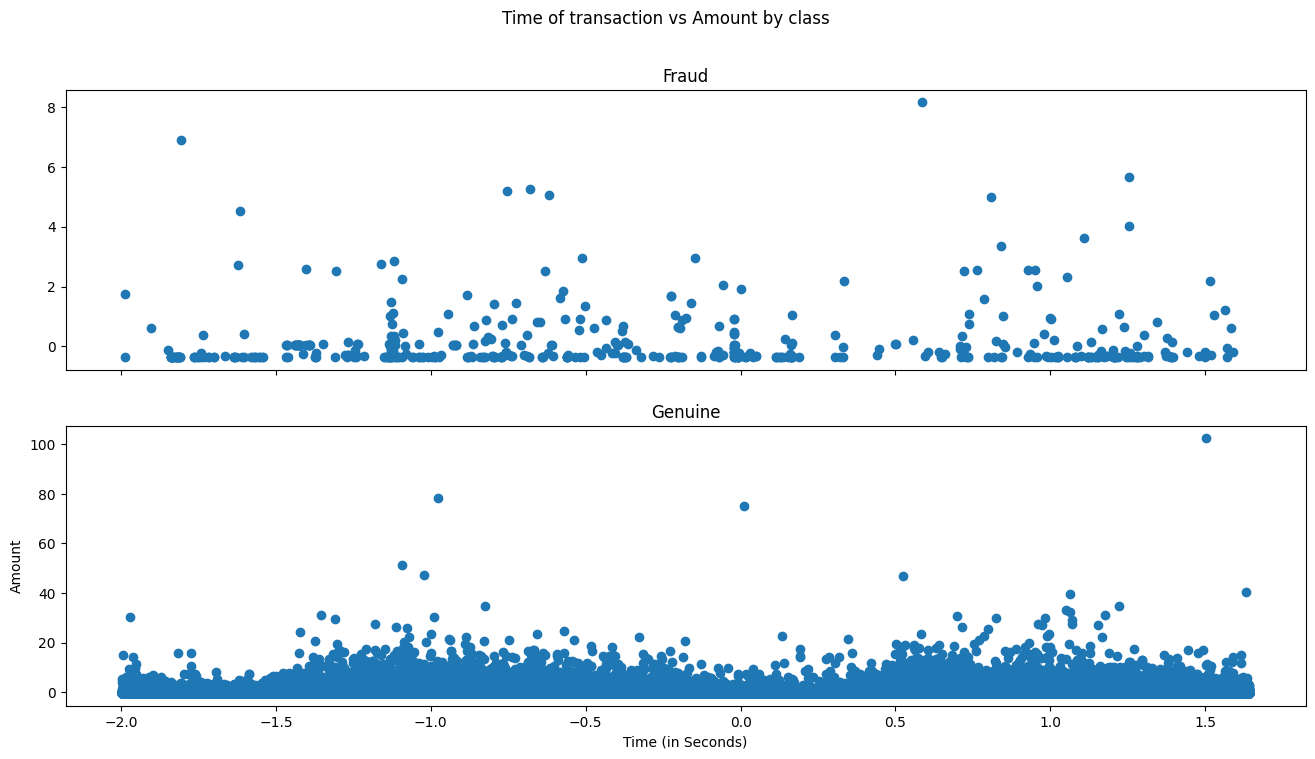

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 16, 8
f,(ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(genuine.Time, genuine.Amount)
ax2.set_title('Genuine')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [18]:

print("Missing in Class column:", df['Class'].isnull().sum())

df = df.dropna(subset=['Class'])

print("After cleaning:", df['Class'].isnull().sum())

X = df.drop('Class', axis=1)
y = df['Class']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Missing in Class column: 0
After cleaning: 0


In [19]:
fraud_cases=len(df[df['Class']==1])
print(' Number of Fraud Cases:',fraud_cases)

 Number of Fraud Cases: 492


In [42]:
fraud_df = df[df['Class'] == 1]
print("Total Fraudulent Transactions:", fraud_df.shape[0])
fraud_df.head()

Total Fraudulent Transactions: 492


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,-1.988034,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.353229,1
623,-1.986644,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758,1
4920,-1.902623,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.606031,1
6108,-1.849472,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.117342,1
6329,-1.838248,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.349231,1


In [20]:
# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [22]:
rf_smote_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_model.fit(X_train_smote, y_train_smote)


RandomForestClassifier(random_state=42)

In [23]:

y_pred = rf_model.predict(X_test)
print("Normal RandomForest")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))


Normal RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

[[56859     5]
 [   18    80]]
AUC: 0.9081193007591333


In [25]:

y_pred_smote = rf_smote_model.predict(X_test)
print("SMOTE RandomForest")
print(classification_report(y_test, y_pred_smote))
print(confusion_matrix(y_test, y_pred_smote))
print("AUC:", roc_auc_score(y_test, y_pred_smote))


SMOTE RandomForest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.84      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

[[56849    15]
 [   16    82]]
AUC: 0.9182354532978076


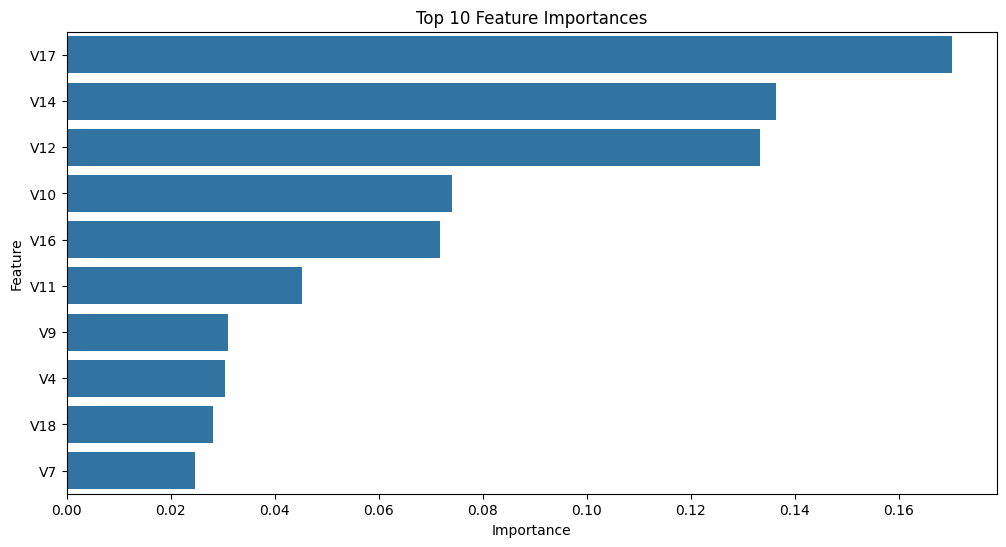

In [26]:
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()


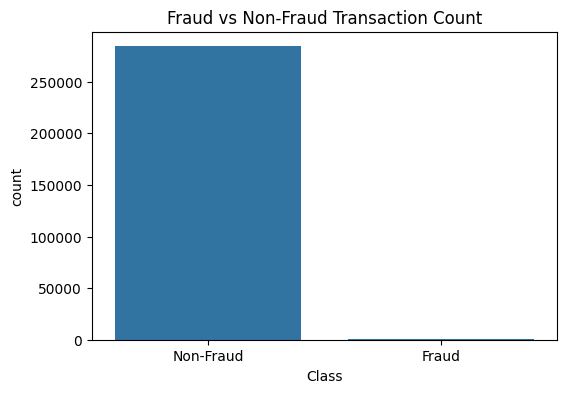

In [27]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Transaction Count")
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.show()

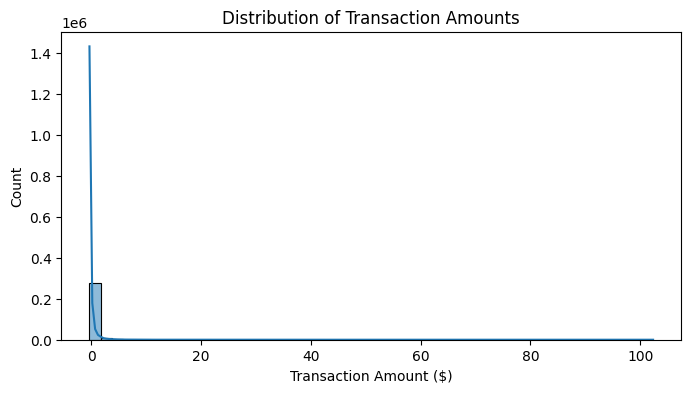

In [28]:
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount ($)")
plt.show()

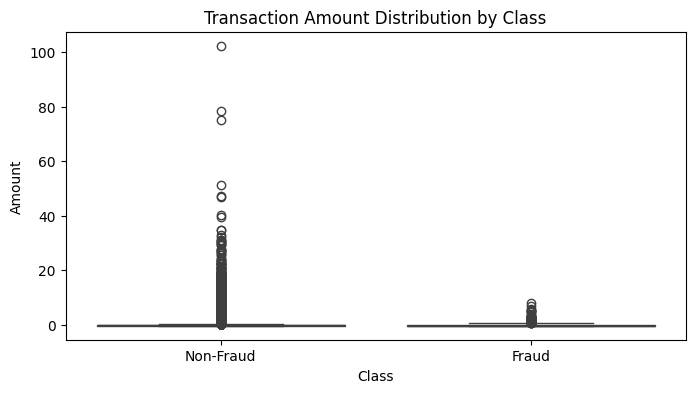

In [29]:

plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Transaction Amount Distribution by Class")
plt.xticks([0,1], ['Non-Fraud', 'Fraud'])
plt.show()

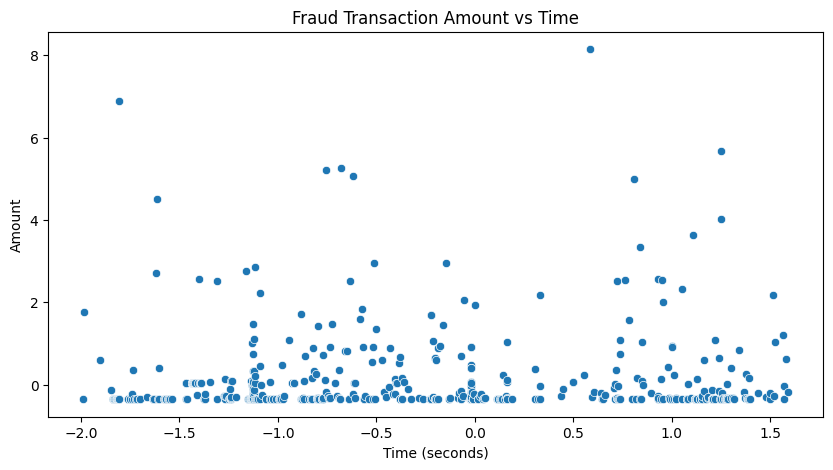

In [30]:

fraud_df = df[df['Class'] == 1]

plt.figure(figsize=(10,5))
sns.scatterplot(x='Time', y='Amount', data=fraud_df)
plt.title("Fraud Transaction Amount vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Amount")
plt.show()

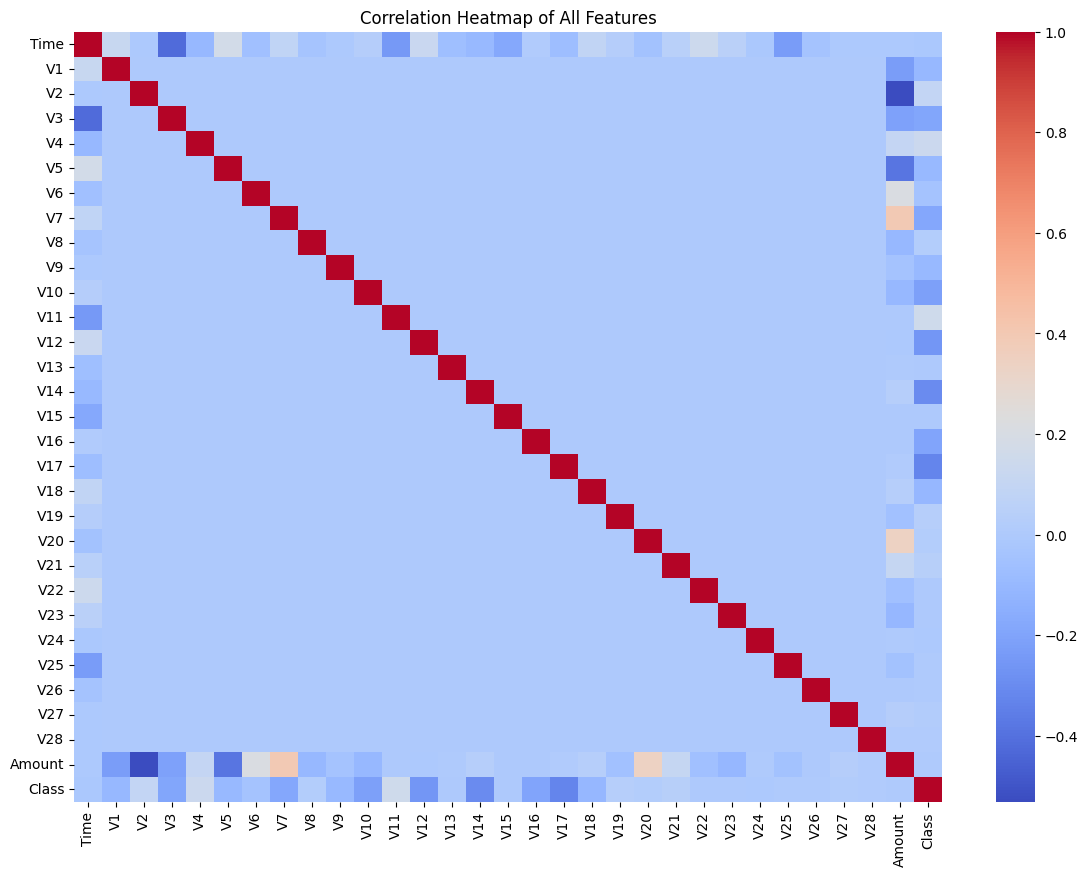

In [31]:
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of All Features")
plt.show()


<ipython-input-32-14f4264be2b2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='viridis')


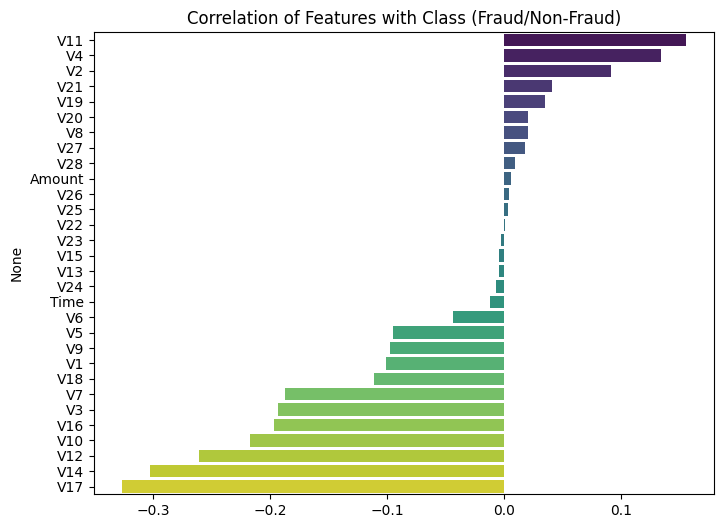

In [32]:

corr_target = df.corr()['Class'].drop('Class').sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='viridis')
plt.title("Correlation of Features with Class (Fraud/Non-Fraud)")
plt.show()

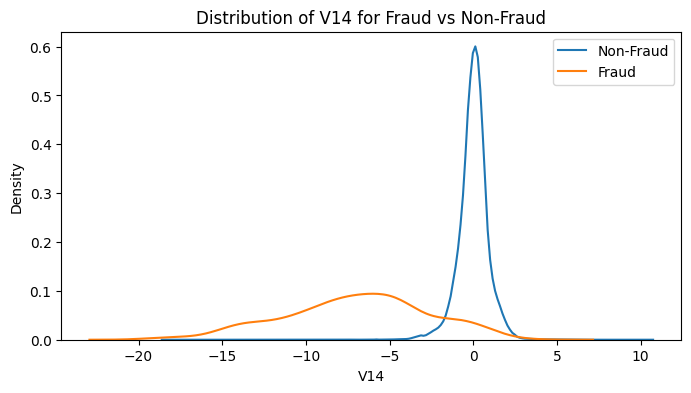

In [33]:

plt.figure(figsize=(8,4))
sns.kdeplot(df.loc[df['Class'] == 0, 'V14'], label='Non-Fraud')
sns.kdeplot(df.loc[df['Class'] == 1, 'V14'], label='Fraud')
plt.title("Distribution of V14 for Fraud vs Non-Fraud")
plt.legend()
plt.show()

In [34]:
!pip install xgboost lightgbm catboost


In [35]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Prediction
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("AUC Score:", roc_auc_score(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.81      0.86        98

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56857     7]
 [   19    79]]
AUC Score: 0.9029996741240109


In [40]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# Prediction
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluation
print("LightGBM Results:")
print(classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("AUC Score:", roc_auc_score(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339
LightGBM Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.29      0.51      0.37        98

    accuracy                           1.00     56962
   macro avg       0.64      0.75      0.68     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56740   124]
 [   48    50]]
AUC Score: 0.7540117200509916


In [37]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# Prediction
y_pred_cat = cat_model.predict(X_test)

# Evaluation
print("CatBoost Results:")
print(classification_report(y_test, y_pred_cat))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))
print("AUC Score:", roc_auc_score(y_test, y_pred_cat))


CatBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.83      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56860     4]
 [   17    81]]
AUC Score: 0.9132301344848576


In [38]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train, y_train)

# Prediction
y_pred_ada = ada_model.predict(X_test)

# Evaluation
print("AdaBoost Results:")
print(classification_report(y_test, y_pred_ada))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print("AUC Score:", roc_auc_score(y_test, y_pred_ada))


AdaBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.73      0.72        98

    accuracy                           1.00     56962
   macro avg       0.85      0.87      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56834    30]
 [   26    72]]
AUC Score: 0.8670831514935744


In [39]:
# Save models
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(rf_smote_model, 'smote_random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(lgbm_model, 'lightgbm_model.pkl')
joblib.dump(cat_model, 'catboost_model.pkl')
joblib.dump(ada_model, 'adaboost_model.pkl')

['adaboost_model.pkl']

In [41]:
from google.colab import files
files.download('random_forest_model.pkl')
files.download('smote_random_forest_model.pkl')
files.download('xgboost_model.pkl')
files.download('lightgbm_model.pkl')
files.download('catboost_model.pkl')
files.download('adaboost_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

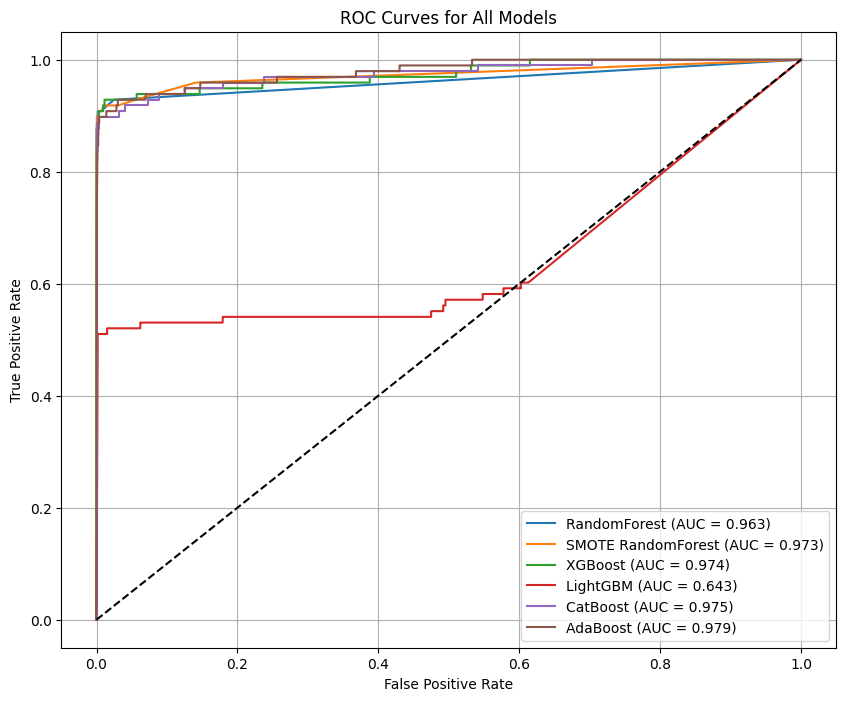

In [44]:
#  Plot the ROC curves
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_roc(model, X_test, y_test, label):
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

plt.figure(figsize=(10,8))

plot_roc(rf_model, X_test, y_test, 'RandomForest')
plot_roc(rf_smote_model, X_test, y_test, 'SMOTE RandomForest')
plot_roc(xgb_model, X_test, y_test, 'XGBoost')
plot_roc(lgbm_model, X_test, y_test, 'LightGBM')
plot_roc(cat_model, X_test, y_test, 'CatBoost')
plot_roc(ada_model, X_test, y_test, 'AdaBoost')

plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
